In [1]:
import random
import warnings
import keras as k
import numpy as np
import pandas as pd
import seaborn as sns
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from models.linear_regression.linear_regression import LinearRegression as LR
import plotly
import plotly.graph_objs as go

import config as c
from sklearn.model_selection import train_test_split
from pipeline.Layer import Layer
from utils.cuda import turn_off_gpu
from models.svm.svm import SVM
from utils.metrics import roc_auc_score_at_K
from utils.preprocess import preprocess 
from models.keras_dense_classifier.keras_dense_classifier import KerasDenseClassifier as KDC
from visualization.utils import plot_correlation_matrix, plot_scatterplot_matrix

#turn_off_gpu()
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
plt.rcParams ['figure.figsize'] = (13,8)
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('train.csv', sep=',')
pd.set_option('display.max_columns', 500)
df['addr_region_fact_encoding2'] = (df['addr_region_fact_encoding2']*11).round(0).astype(int)
df['addr_region_fact_encoding1'] = (df['addr_region_fact_encoding1']*83).round(0).astype(int)
df['addr_region_reg_encoding1'] = (df['addr_region_reg_encoding1']*83).round(0).astype(int)
df['addr_region_reg_encoding2'] = (df['addr_region_reg_encoding2']*11).round(0).astype(int)
df['app_addr_region_reg_encoding2'] = (df['app_addr_region_reg_encoding2']*11).round(0).astype(int)
df['app_addr_region_reg_encoding1'] = (df['app_addr_region_reg_encoding1']*83).round(0).astype(int)
df['app_addr_region_fact_encoding1'] = (df['app_addr_region_fact_encoding1']*83).round(0).astype(int)
df['app_addr_region_fact_encoding2'] = (df['app_addr_region_fact_encoding2']*11).round(0).astype(int)
df['app_addr_region_sale_encoding1'] = (df['app_addr_region_sale_encoding1']*39).round(0).astype(int)
df['app_addr_region_sale_encoding2'] = (df['app_addr_region_sale_encoding2']*7).round(0).astype(int)
df['t_0']=(df['addr_region_fact_encoding1']+df['addr_region_fact_encoding2'])
df['t_1']=(df['addr_region_reg_encoding1']+df['addr_region_reg_encoding2'])
df['t_2']=(df['app_addr_region_reg_encoding2']+df['app_addr_region_reg_encoding1'])
df['t_3']=(df['app_addr_region_fact_encoding2']+df['app_addr_region_fact_encoding1'])
df['t_4']=(df['app_addr_region_sale_encoding2']+df['app_addr_region_sale_encoding1'])
df['notnull'] = np.sum(df.notnull().to_numpy(), axis=1)
df = preprocess(df)
df

,card_id,target,addr_region_reg,addr_region_fact,sas_limit_after_003_amt,sas_limit_last_amt,clnt_income_month_avg_net_amt,clnt_expense_month_avg_amt,clnt_experience_cur_mnth,clnt_experience_cur_year,clnt_experience_total_mnth,app_addr_region_reg,app_addr_region_fact,app_addr_region_sale,clnt_birth_year,addr_region_fact_encoding1,addr_region_fact_encoding2,addr_region_reg_encoding1,addr_region_reg_encoding2,app_addr_region_reg_encoding1,app_addr_region_reg_encoding2,app_addr_region_fact_encoding1,app_addr_region_fact_encoding2,app_addr_region_sale_encoding1,app_addr_region_sale_encoding2,loans_main_borrower,loans_active,last_loan_date,first_loan_date,max_overdue_status,ttl_officials,ttl_legals,ttl_bankruptcies,inquiry_recent_period,inquiry_3_month,inquiry_6_month,inquiry_9_month,inquiry_12_month,ttl_inquiries,ttl_auto_loan,ttl_mortgage,ttl_credit_card,ttl_consumer,worst_status_ever,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,fl_coborrower,fl_active_coborrower,pay_load,inquiry_1_week,inquiry_1_month,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,makro_region,fo,region,feature_30,t_0,t_1,t_2,t_3,t_4,notnull,delivery_type_cat_1,delivery_type_cat_2,delivery_type_cat_3,channel_name_cat_0,channel_name_cat_1,channel_name_cat_2,channel_name_cat_3,channel_name_cat_4,channel_name_cat_5,channel_name_cat_6,channel_name_2_cat_0,channel_name_2_cat_1,channel_name_2_cat_2,channel_name_2_cat_3,channel_name_2_cat_4,channel_name_2_cat_5,channel_name_modified_2018_cat_0,channel_name_modified_2018_cat_1,channel_name_modified_2018_cat_2,channel_name_modified_2018_cat_3,channel_name_modified_2018_cat_4,clnt_education_name_cat_0,clnt_education_name_cat_1,clnt_education_name_cat_2,clnt_education_name_cat_3,clnt_education_name_cat_4,clnt_education_name_cat_5,clnt_education_name_cat_6,clnt_marital_status_name_cat_0,clnt_marital_status_name_cat_1,clnt_marital_status_name_cat_2,clnt_marital_status_name_cat_3,clnt_marital_status_name_cat_4,clnt_employment_type_name_cat_0,clnt_employment_type_name_cat_1,clnt_employment_type_name_cat_2,clnt_employment_type_name_cat_3,clnt_employment_type_name_cat_4,clnt_speciality_sphere_name_cat_0,clnt_speciality_sphere_name_cat_1,clnt_speciality_sphere_name_cat_10,clnt_speciality_sphere_name_cat_11,clnt_speciality_sphere_name_cat_12,clnt_speciality_sphere_name_cat_13,clnt_speciality_sphere_name_cat_14,clnt_speciality_sphere_name_cat_15,clnt_speciality_sphere_name_cat_16,clnt_speciality_sphere_name_cat_17,clnt_speciality_sphere_name_cat_18,clnt_speciality_sphere_name_cat_19,clnt_speciality_sphere_name_cat_2,clnt_speciality_sphere_name_cat_20,clnt_speciality_sphere_name_cat_21,clnt_speciality_sphere_name_cat_22,clnt_speciality_sphere_name_cat_23,clnt_speciality_sphere_name_cat_24,clnt_speciality_sphere_name_cat_25,clnt_speciality_sphere_name_cat_26,clnt_speciality_sphere_name_cat_27,clnt_speciality_sphere_name_cat_28,clnt_speciality_sphere_name_cat_3,clnt_speciality_sphere_name_cat_4,clnt_speciality_sphere_name_cat_5,clnt_speciality_sphere_name_cat_6,clnt_speciality_sphere_name_cat_7,clnt_speciality_sphere_name_cat_8,clnt_speciality_sphere_name_cat_9,clnt_sex_name_cat_0,clnt_sex_name_cat_1,prt_name_cat_0,prt_name_cat_1,prt_name_cat_2,prt_name_cat_3,prt_name_cat_4,prt_name_cat_5,prt_name_cat_6,prt_name_cat_7,prt_name_cat_8,prt_name_cat_9,feature_0_cat_0,feature_0_cat_1,feature_0_cat_10,feature_0_cat_12,feature_0_cat_13,feature_0_cat_14,feature_0_cat_15,feature_0_cat_16,feature_0_cat_3,feature_0_cat_6,feature_0_cat_7,feature_0_cat_8,feature_0_cat_9
0,cid_10620,1,107,107,1,1,3,0,0.0,0.0,0.0,107,107,45,46,560000,78750,560000,78750,560000,78750,560000,78750,260000,46000,0.88,0.78,193.0,2851.0,2,0.0,0.0,0.0,0.0,7.0,10.0,12.0,19.0,87,0,0,1,1,3,3,10,4,0,0,5,1,0,0,0,0,0.82,1.0,3.0,0.57,0.64,0.7,0.0,0.0,0.00,0.00,0.57,0.88,0.0,0.00

In [249]:
from sklearn.metrics import roc_curve, roc_auc_score

In [8]:
def roc_auc_score_at_K(predicted_proba, target, rate=0.1):
    """
    Area under the ROC curve between the predicted probability and the observed target.
    The area under the ROC curve will be calculated only on the top 10 percent of predictions sorted descendingly.
    :param predicted_proba: предсказанное значение
    :param target: истинное значение
    :param rate: процент меток
    :return: roc auc score at k
    """
    order = np.argsort(-predicted_proba)
    top_k = int(rate * len(predicted_proba))
    return roc_auc_score(target[order][:top_k], predicted_proba[order][:top_k])

In [200]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [209]:
from catboost import CatBoostRegressor, CatBoostClassifier


model = CatBoostRegressor(iterations=10, learning_rate=1, task_type="GPU",
                           depth=10,loss_function="RMSE",eval_metric='AUC',
                           od_type = 'Iter', od_wait = 100, verbose = 10, l2_leaf_reg = 20)

model.fit(X_train, y_train, eval_set=(X_test, y_test))

model_ = CatBoostRegressor(iterations=10, learning_rate=1, task_type="GPU",
                           depth=10,loss_function="RMSE",eval_metric='AUC',
                           od_type = 'Iter', od_wait = 100, verbose = 10, l2_leaf_reg = 20)

mask_train = model.predict(X_train)>0.78
mask_test = model.predict(X_test)>0.78
X_train_, y_train_, X_test_, y_test_ = X_train[mask_train], y_train[mask_train],X_test[mask_test], y_test[mask_test] 
model_.fit(X_train_, y_train_, eval_set=(X_test_, y_test_))

0:	learn: 0.7583912	test: 0.6981763	best: 0.6981763 (0)	total: 18.8ms	remaining: 169ms
9:	learn: 0.7876996	test: 0.6966992	best: 0.7001482 (2)	total: 184ms	remaining: 0us
bestTest = 0.7001482061
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.6394389	test: 0.5518427	best: 0.5518427 (0)	total: 14.2ms	remaining: 127ms
9:	learn: 0.8239082	test: 0.5469251	best: 0.5630637 (2)	total: 132ms	remaining: 0us
bestTest = 0.5630636764
bestIteration = 2
Shrink model to first 3 iterations.


In [210]:
roc_auc_score_at_K(model.predict(X_train), y_train, rate=0.1)

0.5800762438709395

In [267]:
roc_auc_score_at_K(model.predict(X_test), y_test, rate=0.1)

0.5046617959348423

In [347]:
yproba = model.predict(X_test)

order = np.argsort(-yproba)
top_k = int(0.05 * len(yproba))
yproba[(yproba<yproba[order][top_k])&(yproba>yproba[order][-top_k])]=-1

roc_auc_score_at_K(yproba, y_test, rate=0.1)

0.7904758687271819

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [245]:
predicted_proba = model.predict(X_test)
target = y_test

order = np.argsort(-predicted_proba)
top_k = int(0.1 * len(predicted_proba))

print(sum(target[order][:top_k]), top_k-sum(target[order][:top_k]))
print(roc_auc_score(target[order][:top_k], predicted_proba[order][:top_k]))

2353 617
0.5046617959348423


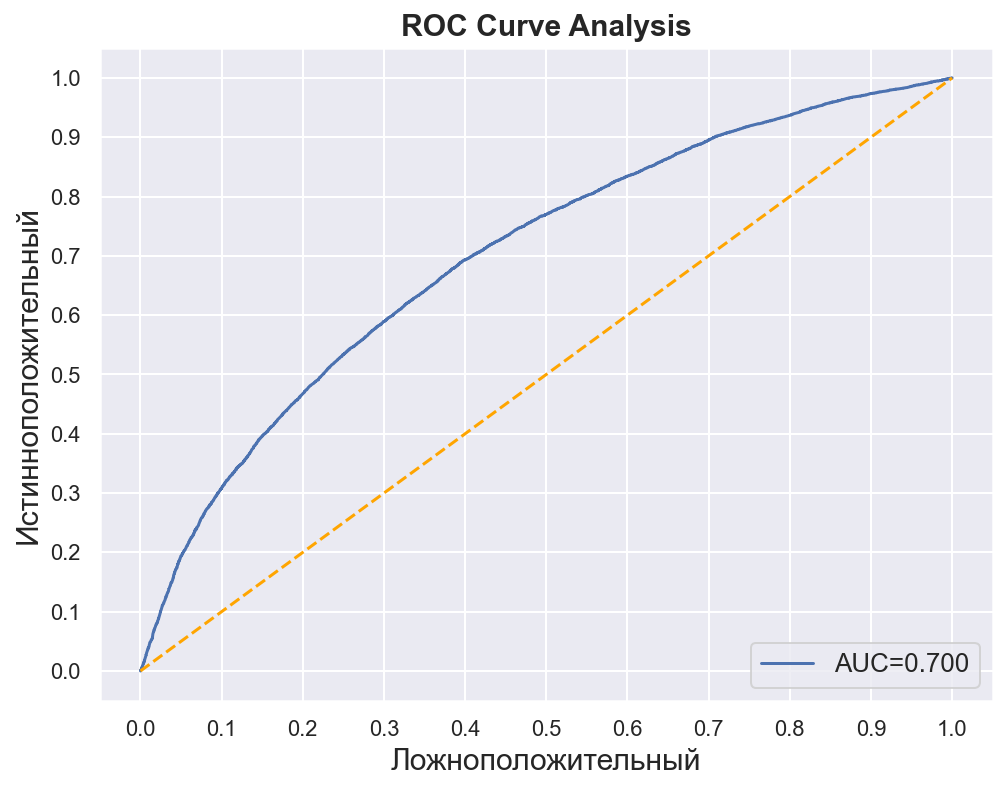

In [348]:
yproba = model.predict(X_test)
target = y_test

order = np.argsort(-predicted_proba)
top_k = int(0.1 * len(predicted_proba))

yproba = yproba[order]#[:top_k]
target = target[order]#[:top_k]


fpr, tpr, _ = roc_curve(target,  yproba)
auc = roc_auc_score(target, yproba)
fig = plt.figure(figsize=(8,6))

plt.plot(fpr,          tpr, 
         label="AUC={:.3f}".format(auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')



plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Ложноположительный", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Истинноположительный", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [322]:
sum(target)/len(target)

0.49139543583988027

In [321]:
#yproba[(target==0)&(yproba<0.9)]=0
roc_auc_score(target, yproba)

0.6783423925559859

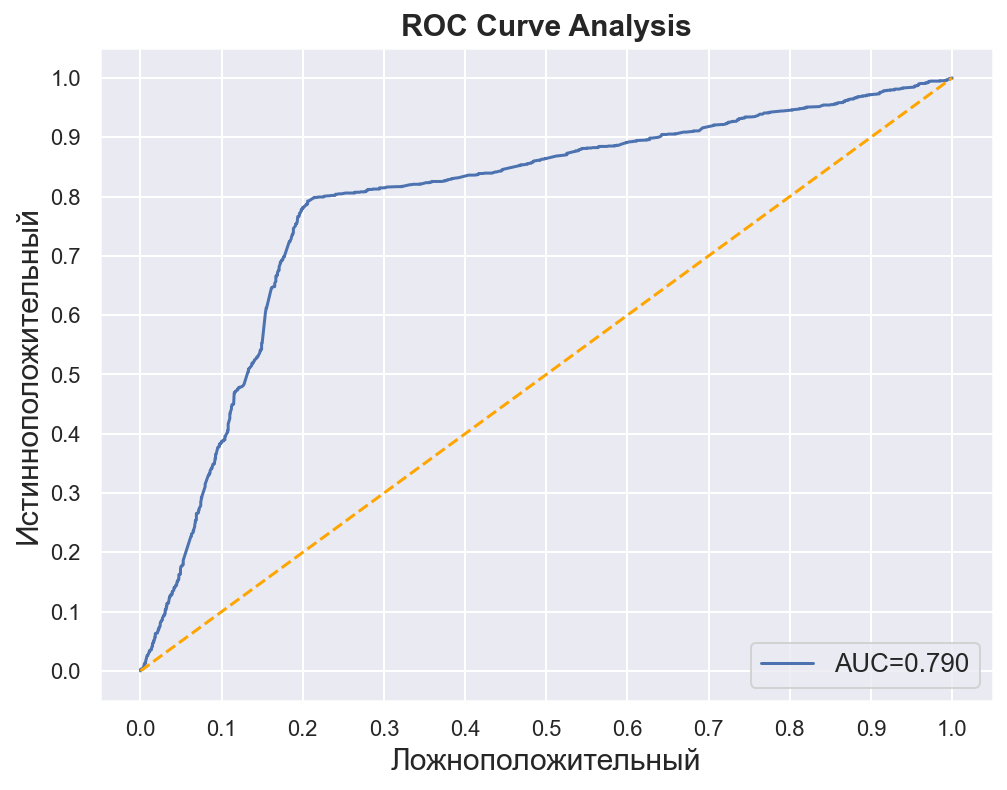

In [358]:
yproba = model.predict(X_test)
target = y_test

order = np.argsort(-yproba)
top_k = int(0.05 * len(yproba))

yproba=yproba[order]
target=target[order]

yproba[top_k:-top_k]=-1
#target[order][top_k:-top_k]=0

order = np.argsort(-yproba)
top_k = int(0.10 * len(yproba))
yproba = yproba[order][:top_k]
target = target[order][:top_k]

fpr, tpr, _ = roc_curve(target,  yproba)
auc = roc_auc_score(target, yproba)
fig = plt.figure(figsize=(8,6))

plt.plot(fpr,          tpr, 
         label="AUC={:.3f}".format(auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')



plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Ложноположительный", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Истинноположительный", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [243]:
sum(predicted_proba[order][:top_k])

2557.750574995618

In [244]:
sum(predicted_proba[order][:top_k])

2557.750574995618

In [158]:
predict=model.predict(X)
top_k = int(0.1 * len(predict))
predict[np.argsort(-predict)][:top_k]

array([1.1782304 , 1.17511986, 1.17363734, ..., 0.78098059, 0.78095303,
       0.78095251])

In [130]:
df['predict'] = model.predict(X)

In [147]:
df[df.predict >= 0.78095251][df.target == 0]

,card_id,target,addr_region_reg,addr_region_fact,sas_limit_after_003_amt,sas_limit_last_amt,clnt_income_month_avg_net_amt,clnt_expense_month_avg_amt,clnt_experience_cur_mnth,clnt_experience_cur_year,clnt_experience_total_mnth,app_addr_region_reg,app_addr_region_fact,app_addr_region_sale,clnt_birth_year,addr_region_fact_encoding1,addr_region_fact_encoding2,addr_region_reg_encoding1,addr_region_reg_encoding2,app_addr_region_reg_encoding1,app_addr_region_reg_encoding2,app_addr_region_fact_encoding1,app_addr_region_fact_encoding2,app_addr_region_sale_encoding1,app_addr_region_sale_encoding2,loans_main_borrower,loans_active,last_loan_date,first_loan_date,max_overdue_status,ttl_officials,ttl_legals,ttl_bankruptcies,inquiry_recent_period,inquiry_3_month,inquiry_6_month,inquiry_9_month,inquiry_12_month,ttl_inquiries,ttl_auto_loan,ttl_mortgage,ttl_credit_card,ttl_consumer,worst_status_ever,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,fl_coborrower,fl_active_coborrower,pay_load,inquiry_1_week,inquiry_1_month,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,makro_region,fo,region,feature_30,t_0,t_1,t_2,t_3,t_4,notnull,delivery_type_cat_1,delivery_type_cat_2,delivery_type_cat_3,channel_name_cat_0,channel_name_cat_1,channel_name_cat_2,channel_name_cat_3,channel_name_cat_4,channel_name_cat_5,channel_name_cat_6,channel_name_2_cat_0,channel_name_2_cat_1,channel_name_2_cat_2,channel_name_2_cat_3,channel_name_2_cat_4,channel_name_2_cat_5,channel_name_modified_2018_cat_0,channel_name_modified_2018_cat_1,channel_name_modified_2018_cat_2,channel_name_modified_2018_cat_3,channel_name_modified_2018_cat_4,clnt_education_name_cat_0,clnt_education_name_cat_1,clnt_education_name_cat_2,clnt_education_name_cat_3,clnt_education_name_cat_4,clnt_education_name_cat_5,clnt_education_name_cat_6,clnt_marital_status_name_cat_0,clnt_marital_status_name_cat_1,clnt_marital_status_name_cat_2,clnt_marital_status_name_cat_3,clnt_marital_status_name_cat_4,clnt_employment_type_name_cat_0,clnt_employment_type_name_cat_1,clnt_employment_type_name_cat_2,clnt_employment_type_name_cat_3,clnt_employment_type_name_cat_4,clnt_speciality_sphere_name_cat_0,clnt_speciality_sphere_name_cat_1,clnt_speciality_sphere_name_cat_10,clnt_speciality_sphere_name_cat_11,clnt_speciality_sphere_name_cat_12,clnt_speciality_sphere_name_cat_13,clnt_speciality_sphere_name_cat_14,clnt_speciality_sphere_name_cat_15,clnt_speciality_sphere_name_cat_16,clnt_speciality_sphere_name_cat_17,clnt_speciality_sphere_name_cat_18,clnt_speciality_sphere_name_cat_19,clnt_speciality_sphere_name_cat_2,clnt_speciality_sphere_name_cat_20,clnt_speciality_sphere_name_cat_21,clnt_speciality_sphere_name_cat_22,clnt_speciality_sphere_name_cat_23,clnt_speciality_sphere_name_cat_24,clnt_speciality_sphere_name_cat_25,clnt_speciality_sphere_name_cat_26,clnt_speciality_sphere_name_cat_27,clnt_speciality_sphere_name_cat_28,clnt_speciality_sphere_name_cat_3,clnt_speciality_sphere_name_cat_4,clnt_speciality_sphere_name_cat_5,clnt_speciality_sphere_name_cat_6,clnt_speciality_sphere_name_cat_7,clnt_speciality_sphere_name_cat_8,clnt_speciality_sphere_name_cat_9,clnt_sex_name_cat_0,clnt_sex_name_cat_1,prt_name_cat_0,prt_name_cat_1,prt_name_cat_2,prt_name_cat_3,prt_name_cat_4,prt_name_cat_5,prt_name_cat_6,prt_name_cat_7,prt_name_cat_8,prt_name_cat_9,feature_0_cat_0,feature_0_cat_1,feature_0_cat_10,feature_0_cat_12,feature_0_cat_13,feature_0_cat_14,feature_0_cat_15,feature_0_cat_16,feature_0_cat_3,feature_0_cat_6,feature_0_cat_7,feature_0_cat_8,feature_0_cat_9,predict
30,cid_51279,0,37,37,3,3,3,0,0.0,0.0,2.0,37,37,1,38,720000,97500,700000,95000,700000,95000,720000,97500,310000,54000,0.72,0.39,1602.0,4530.0,1,0.0,0.0,0.0,0.0,19.0,19.0,20.0,25.0,59,0,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0.00,16.0,16.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

In [148]:
df[df.predict >= 0.78095251][df.target == 1]

,card_id,target,addr_region_reg,addr_region_fact,sas_limit_after_003_amt,sas_limit_last_amt,clnt_income_month_avg_net_amt,clnt_expense_month_avg_amt,clnt_experience_cur_mnth,clnt_experience_cur_year,clnt_experience_total_mnth,app_addr_region_reg,app_addr_region_fact,app_addr_region_sale,clnt_birth_year,addr_region_fact_encoding1,addr_region_fact_encoding2,addr_region_reg_encoding1,addr_region_reg_encoding2,app_addr_region_reg_encoding1,app_addr_region_reg_encoding2,app_addr_region_fact_encoding1,app_addr_region_fact_encoding2,app_addr_region_sale_encoding1,app_addr_region_sale_encoding2,loans_main_borrower,loans_active,last_loan_date,first_loan_date,max_overdue_status,ttl_officials,ttl_legals,ttl_bankruptcies,inquiry_recent_period,inquiry_3_month,inquiry_6_month,inquiry_9_month,inquiry_12_month,ttl_inquiries,ttl_auto_loan,ttl_mortgage,ttl_credit_card,ttl_consumer,worst_status_ever,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,fl_coborrower,fl_active_coborrower,pay_load,inquiry_1_week,inquiry_1_month,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,makro_region,fo,region,feature_30,t_0,t_1,t_2,t_3,t_4,notnull,delivery_type_cat_1,delivery_type_cat_2,delivery_type_cat_3,channel_name_cat_0,channel_name_cat_1,channel_name_cat_2,channel_name_cat_3,channel_name_cat_4,channel_name_cat_5,channel_name_cat_6,channel_name_2_cat_0,channel_name_2_cat_1,channel_name_2_cat_2,channel_name_2_cat_3,channel_name_2_cat_4,channel_name_2_cat_5,channel_name_modified_2018_cat_0,channel_name_modified_2018_cat_1,channel_name_modified_2018_cat_2,channel_name_modified_2018_cat_3,channel_name_modified_2018_cat_4,clnt_education_name_cat_0,clnt_education_name_cat_1,clnt_education_name_cat_2,clnt_education_name_cat_3,clnt_education_name_cat_4,clnt_education_name_cat_5,clnt_education_name_cat_6,clnt_marital_status_name_cat_0,clnt_marital_status_name_cat_1,clnt_marital_status_name_cat_2,clnt_marital_status_name_cat_3,clnt_marital_status_name_cat_4,clnt_employment_type_name_cat_0,clnt_employment_type_name_cat_1,clnt_employment_type_name_cat_2,clnt_employment_type_name_cat_3,clnt_employment_type_name_cat_4,clnt_speciality_sphere_name_cat_0,clnt_speciality_sphere_name_cat_1,clnt_speciality_sphere_name_cat_10,clnt_speciality_sphere_name_cat_11,clnt_speciality_sphere_name_cat_12,clnt_speciality_sphere_name_cat_13,clnt_speciality_sphere_name_cat_14,clnt_speciality_sphere_name_cat_15,clnt_speciality_sphere_name_cat_16,clnt_speciality_sphere_name_cat_17,clnt_speciality_sphere_name_cat_18,clnt_speciality_sphere_name_cat_19,clnt_speciality_sphere_name_cat_2,clnt_speciality_sphere_name_cat_20,clnt_speciality_sphere_name_cat_21,clnt_speciality_sphere_name_cat_22,clnt_speciality_sphere_name_cat_23,clnt_speciality_sphere_name_cat_24,clnt_speciality_sphere_name_cat_25,clnt_speciality_sphere_name_cat_26,clnt_speciality_sphere_name_cat_27,clnt_speciality_sphere_name_cat_28,clnt_speciality_sphere_name_cat_3,clnt_speciality_sphere_name_cat_4,clnt_speciality_sphere_name_cat_5,clnt_speciality_sphere_name_cat_6,clnt_speciality_sphere_name_cat_7,clnt_speciality_sphere_name_cat_8,clnt_speciality_sphere_name_cat_9,clnt_sex_name_cat_0,clnt_sex_name_cat_1,prt_name_cat_0,prt_name_cat_1,prt_name_cat_2,prt_name_cat_3,prt_name_cat_4,prt_name_cat_5,prt_name_cat_6,prt_name_cat_7,prt_name_cat_8,prt_name_cat_9,feature_0_cat_0,feature_0_cat_1,feature_0_cat_10,feature_0_cat_12,feature_0_cat_13,feature_0_cat_14,feature_0_cat_15,feature_0_cat_16,feature_0_cat_3,feature_0_cat_6,feature_0_cat_7,feature_0_cat_8,feature_0_cat_9,predict
20,cid_29520,1,12,12,2,2,3,0,4.0,0.0,2.0,12,12,1,38,520000,72500,520000,72500,520000,72500,520000,72500,310000,54000,0.79,0.39,377.0,4380.0,1,0.0,0.0,0.0,0.0,10.0,14.0,14.0,20.0,48,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0.85,9.0,9.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [161]:
pd.set_option('display.max_row', 500)
df[df.predict >= 0.78095251].corr()

,target,addr_region_reg,addr_region_fact,sas_limit_after_003_amt,sas_limit_last_amt,clnt_income_month_avg_net_amt,clnt_expense_month_avg_amt,clnt_experience_cur_mnth,clnt_experience_cur_year,clnt_experience_total_mnth,app_addr_region_reg,app_addr_region_fact,app_addr_region_sale,clnt_birth_year,addr_region_fact_encoding1,addr_region_fact_encoding2,addr_region_reg_encoding1,addr_region_reg_encoding2,app_addr_region_reg_encoding1,app_addr_region_reg_encoding2,app_addr_region_fact_encoding1,app_addr_region_fact_encoding2,app_addr_region_sale_encoding1,app_addr_region_sale_encoding2,loans_main_borrower,loans_active,last_loan_date,first_loan_date,max_overdue_status,ttl_officials,ttl_legals,ttl_bankruptcies,inquiry_recent_period,inquiry_3_month,inquiry_6_month,inquiry_9_month,inquiry_12_month,ttl_inquiries,ttl_auto_loan,ttl_mortgage,ttl_credit_card,ttl_consumer,worst_status_ever,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,fl_coborrower,fl_active_coborrower,pay_load,inquiry_1_week,inquiry_1_month,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,makro_region,fo,region,feature_30,t_0,t_1,t_2,t_3,t_4,notnull,delivery_type_cat_1,delivery_type_cat_2,delivery_type_cat_3,channel_name_cat_0,channel_name_cat_1,channel_name_cat_2,channel_name_cat_3,channel_name_cat_4,channel_name_cat_5,channel_name_cat_6,channel_name_2_cat_0,channel_name_2_cat_1,channel_name_2_cat_2,channel_name_2_cat_3,channel_name_2_cat_4,channel_name_2_cat_5,channel_name_modified_2018_cat_0,channel_name_modified_2018_cat_1,channel_name_modified_2018_cat_2,channel_name_modified_2018_cat_3,channel_name_modified_2018_cat_4,clnt_education_name_cat_0,clnt_education_name_cat_1,clnt_education_name_cat_2,clnt_education_name_cat_3,clnt_education_name_cat_4,clnt_education_name_cat_5,clnt_education_name_cat_6,clnt_marital_status_name_cat_0,clnt_marital_status_name_cat_1,clnt_marital_status_name_cat_2,clnt_marital_status_name_cat_3,clnt_marital_status_name_cat_4,clnt_employment_type_name_cat_0,clnt_employment_type_name_cat_1,clnt_employment_type_name_cat_2,clnt_employment_type_name_cat_3,clnt_employment_type_name_cat_4,clnt_speciality_sphere_name_cat_0,clnt_speciality_sphere_name_cat_1,clnt_speciality_sphere_name_cat_10,clnt_speciality_sphere_name_cat_11,clnt_speciality_sphere_name_cat_12,clnt_speciality_sphere_name_cat_13,clnt_speciality_sphere_name_cat_14,clnt_speciality_sphere_name_cat_15,clnt_speciality_sphere_name_cat_16,clnt_speciality_sphere_name_cat_17,clnt_speciality_sphere_name_cat_18,clnt_speciality_sphere_name_cat_19,clnt_speciality_sphere_name_cat_2,clnt_speciality_sphere_name_cat_20,clnt_speciality_sphere_name_cat_21,clnt_speciality_sphere_name_cat_22,clnt_speciality_sphere_name_cat_23,clnt_speciality_sphere_name_cat_24,clnt_speciality_sphere_name_cat_25,clnt_speciality_sphere_name_cat_26,clnt_speciality_sphere_name_cat_27,clnt_speciality_sphere_name_cat_28,clnt_speciality_sphere_name_cat_3,clnt_speciality_sphere_name_cat_4,clnt_speciality_sphere_name_cat_5,clnt_speciality_sphere_name_cat_6,clnt_speciality_sphere_name_cat_7,clnt_speciality_sphere_name_cat_8,clnt_speciality_sphere_name_cat_9,clnt_sex_name_cat_0,clnt_sex_name_cat_1,prt_name_cat_0,prt_name_cat_1,prt_name_cat_2,prt_name_cat_3,prt_name_cat_4,prt_name_cat_5,prt_name_cat_6,prt_name_cat_7,prt_name_cat_8,prt_name_cat_9,feature_0_cat_0,feature_0_cat_1,feature_0_cat_10,feature_0_cat_12,feature_0_cat_13,feature_0_cat_14,feature_0_cat_15,feature_0_cat_16,feature_0_cat_3,feature_0_cat_6,feature_0_cat_7,feature_0_cat_8,feature_0_cat_9,predict
target,1.000000,0.010631,0.013875,-0.005894,-0.005916,0.007742,-0.004237,0.061047,0.004548,0.042549,0.010624,0.010770,-0.024810,0.004282,-0.024979,-0.026983,-0.008703,-0.010677,-0.008627,-0.010726,-0.024564,-0.026421,0.019238,0.018832,0.007501,-0.038898,0.007214,0.033660,-0.00699

<AxesSubplot:ylabel='Density'>

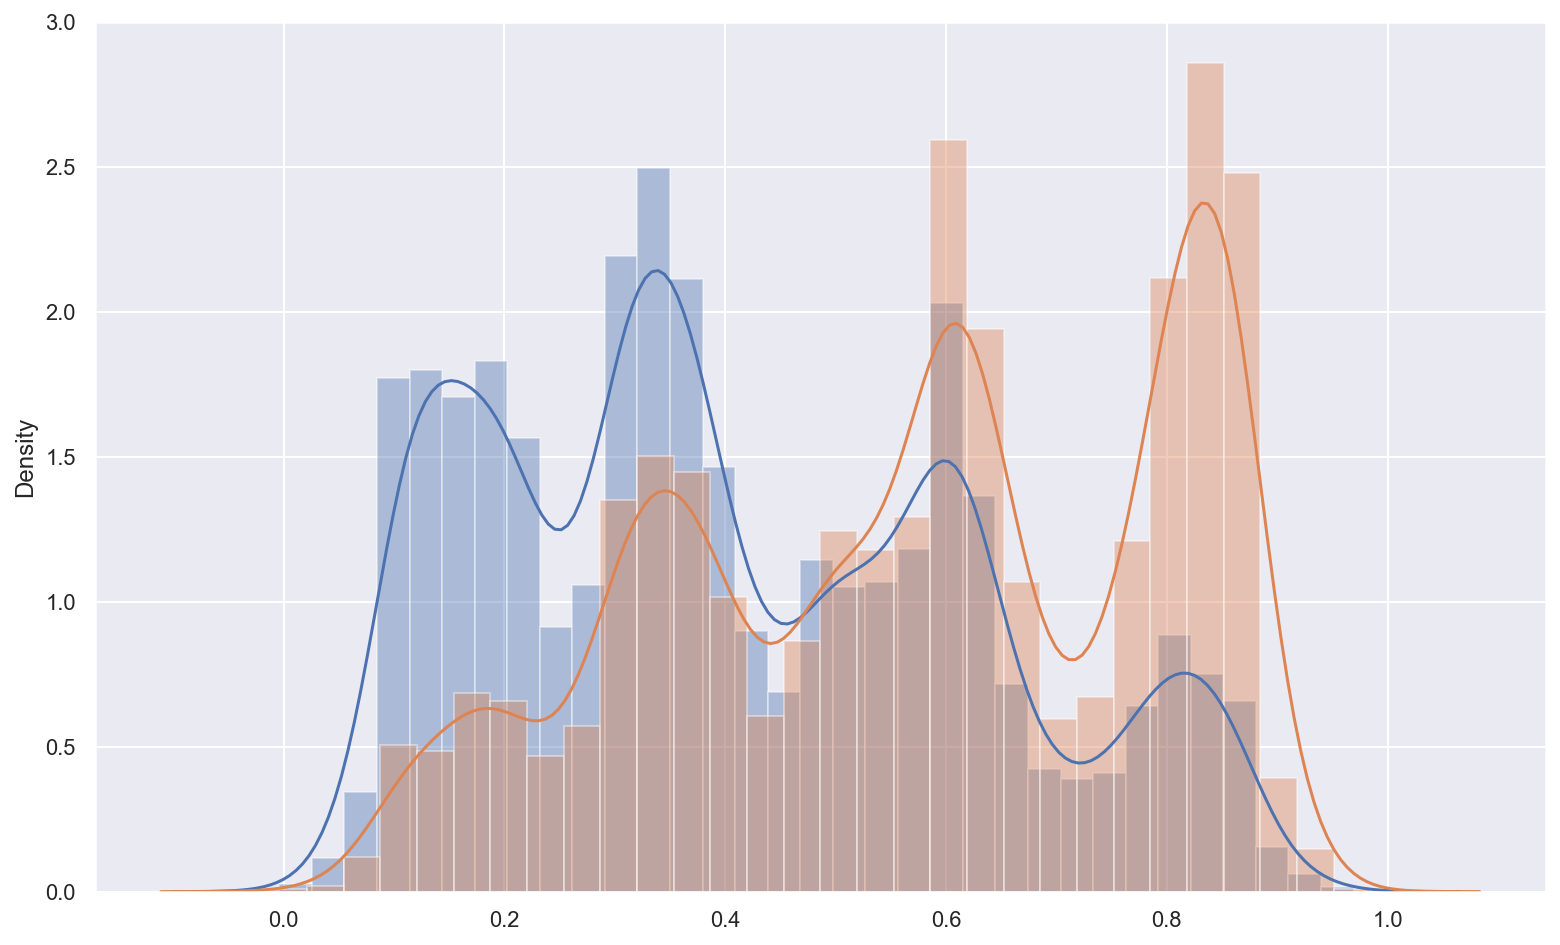

In [242]:
predict=model.predict(X_test)
sns.distplot(predict[y_test==0])
sns.distplot(predict[y_test==1])

In [45]:
import xgboost as xgb
from sklearn import metrics




# Parameter Tuning
model = xgb.XGBRegressor()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
param_dist['gpu_id'] = 0
param_dist['tree_method'] = 'gpu_hist'
"""
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X, y)

grid_search.best_estimator_
"""
model = xgb.XGBRegressor(max_depth=50, min_child_weight=1,  n_estimators=200,\
                          n_jobs=-1 , verbose=1,learning_rate=0.16)
model.fit(X_train,y_train)

[09:31:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.16, max_delta_step=0, max_depth=50,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbose=1,
             verbosity=None)

In [101]:
model.predict(X_test)

array([0.61395508, 0.6961838 , 0.17061862, ..., 0.26960611, 0.50190867,
       0.56025117])

In [10]:
from sklearn.metrics import roc_auc_score

In [102]:
predicted_proba = model.predict(X_test)
target = y_test

order = np.argsort(-predicted_proba)
top_k = int(0.1 * len(predicted_proba))

target[order][:top_k]
predicted_proba[order][:top_k]

array([1.7637108 , 1.64660753, 1.64533695, ..., 0.9231119 , 0.92305387,
       0.92299957])

In [103]:
roc_auc_score(target[order][:top_k], predicted_proba[order][:top_k])

0.5406010203806657

In [111]:
sum(target[order][:top_k]==1)/top_k

0.7094276094276094

In [112]:
sum(target[order][:top_k]==0)/top_k

0.2905723905723906

In [310]:
df=pd.concat([df.iloc[:,13:23], df.iloc[:,1]], axis=1)

In [221]:
df['t_0']=(df['addr_region_fact_encoding1']+df['addr_region_fact_encoding2'])
df['t_1']=(df['addr_region_reg_encoding1']+df['addr_region_reg_encoding2'])
df['t_2']=(df['app_addr_region_reg_encoding2']+df['app_addr_region_reg_encoding1'])
df['t_3']=(df['app_addr_region_fact_encoding2']+df['app_addr_region_fact_encoding1'])
df['t_4']=(df['app_addr_region_sale_encoding2']+df['app_addr_region_sale_encoding1'])
t_list=['t_0', 't_1', 't_2', 't_3', 't_4']
#df=df.iloc[:,-5:]
unique_list = np.unique(df.t_0.to_list()+df.t_1.to_list()+df.t_2.to_list()+df.t_3.to_list()+df.t_4.to_list())

In [222]:
df[t_list].value_counts()

t_0     t_1     t_2     t_3     t_4   
680000  680000  680000  680000  182000    5990
940000  940000  940000  940000  460000    5978
910000  910000  910000  910000  364000    4951
822500  822500  822500  822500  364000    3031
940000  940000  940000  940000  364000    3004
                                          ... 
702500  738750  738750  702500  364000       1
        702500  702500  702500  332000       1
                                182000       1
                                132000       1
0       0       0       0       90000        1
Length: 1853, dtype: int64

In [227]:
df[df.t_1==680000][t_list[:-1]].value_counts()

t_0     t_1     t_2     t_3   
680000  680000  680000  680000    8703
940000  680000  680000  940000     180
910000  680000  680000  910000     116
822500  680000  680000  822500      48
668750  680000  680000  668750      32
817500  680000  680000  680000      26
795000  680000  680000  795000      26
745000  680000  680000  745000      23
817500  680000  680000  817500      13
738750  680000  680000  738750      11
670000  680000  680000  670000       8
633750  680000  680000  633750       5
702500  680000  680000  702500       5
638750  680000  680000  638750       4
576250  680000  680000  576250       4
592500  680000  680000  592500       3
601250  680000  680000  601250       3
616250  680000  680000  616250       3
746250  680000  680000  746250       3
757500  680000  680000  757500       3
713750  680000  680000  713750       2
542500  680000  680000  542500       2
748750  680000  680000  748750       2
557500  680000  680000  557500       2
701250  680000  680000  701250   

In [423]:
unique_list = np.unique(df.t_0.to_list()+df.t_1.to_list()+df.t_2.to_list()+df.t_3.to_list())
len(unique_list)

68

In [230]:
df["_"]=(df.t_0==680000)&(df.t_1==680000)&(df.t_2==680000)&(df.t_3==680000)*1

In [232]:
df.corr()['_']

target                                0.022808
addr_region_reg                      -0.195847
addr_region_fact                     -0.195003
sas_limit_after_003_amt              -0.133515
sas_limit_last_amt                   -0.133342
clnt_income_month_avg_net_amt        -0.110270
clnt_expense_month_avg_amt           -0.069098
clnt_experience_cur_mnth             -0.030429
clnt_experience_cur_year             -0.001091
clnt_experience_total_mnth           -0.083682
app_addr_region_reg                  -0.195726
app_addr_region_fact                 -0.203686
app_addr_region_sale                 -0.017945
clnt_birth_year                       0.078076
addr_region_fact_encoding1           -0.176983
addr_region_fact_encoding2           -0.185721
addr_region_reg_encoding1            -0.129052
addr_region_reg_encoding2            -0.140790
app_addr_region_reg_encoding1        -0.128990
app_addr_region_reg_encoding2        -0.140737
app_addr_region_fact_encoding1       -0.173069
app_addr_regi

In [449]:
df = preprocess(df)

In [14]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

In [15]:
lr = LR()
lr.create_model(LR.default_model_constructor_parameters)
lr.fit_model(X, y, test_size=0.0)
lr.save_model()
roc_auc_score_at_K(lr.predict(X).reshape(-1), y, rate=0.1)

0.5571704230641429

In [458]:
predict = lr.predict(X).reshape(-1)

In [459]:

top_k = int(0.1 * len(predict)) 


order = np.argsort(-predict)
roc_auc_score(y[order][:top_k], predict[order][:top_k])

0.5557346352601609